C:\Users\elsab\AppData\Local\Temp\ipykernel_30240\3827003054.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[col].fillna(self.data[col].median(), inplace=True)
C:\Users\elsab\AppData\Local\Temp\ipykernel_30240\3827003054.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

                  bedrooms  livingarea  surfaceoftheplot  gardensurface  \
bedrooms          1.000000    0.566866          0.189393       0.096995   
livingarea        0.566866    1.000000          0.260581       0.111693   
surfaceoftheplot  0.189393    0.260581          1.000000       0.551626   
gardensurface     0.096995    0.111693          0.551626       1.000000   
facades           0.267318    0.280500          0.246158       0.125943   
pool              0.127069    0.185103          0.136702       0.067857   
is_apartment     -0.516385   -0.434617         -0.209747      -0.083324   
is_house          0.516385    0.434617          0.209747       0.083324   
price_per_m2     -0.284353   -0.329753         -0.088606      -0.038321   

                   facades      pool  is_apartment  is_house  price_per_m2  
bedrooms          0.267318  0.127069     -0.516385  0.516385     -0.284353  
livingarea        0.280500  0.185103     -0.434617  0.434617     -0.329753  
surfaceoftheplot  

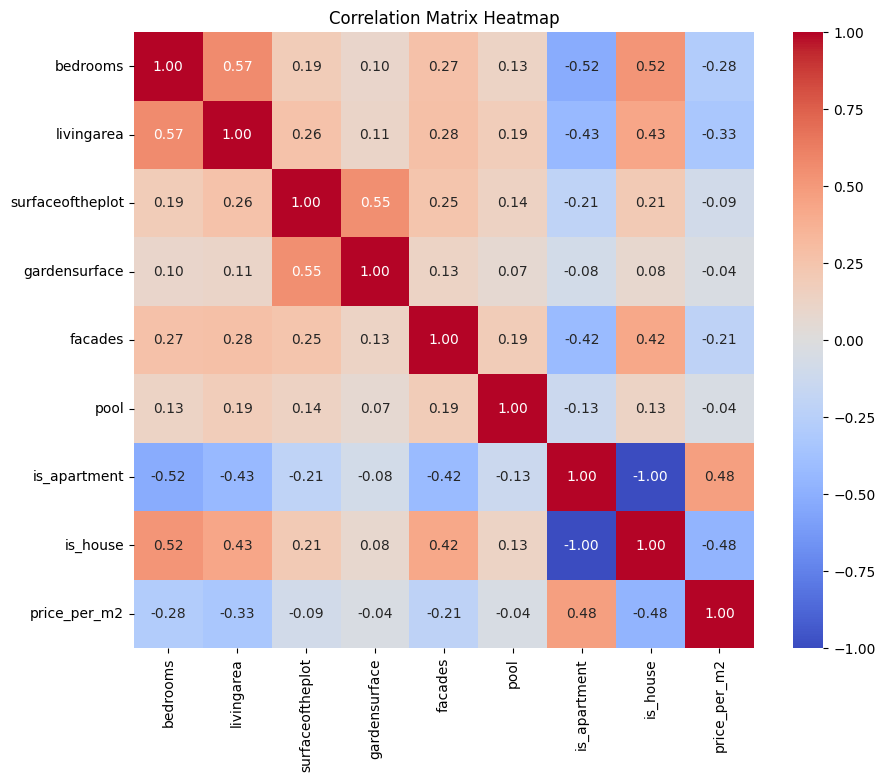

MAE: 174582.85453390158
MSE: 60439704912.240585
R²: 0.24641540976651555


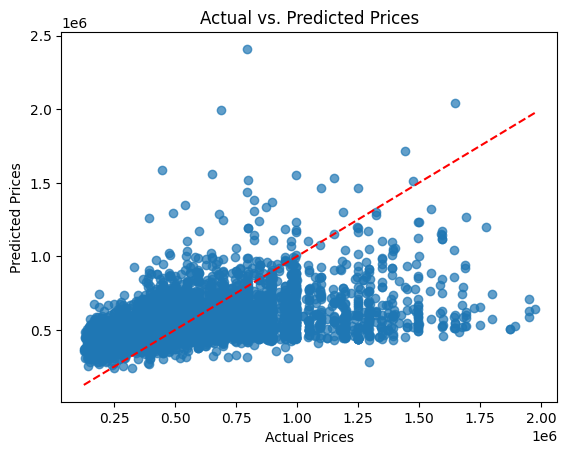

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt



class LinearRegressionModel:
    def __init__(self, data: pd.DataFrame):
        """
        Initializes the LinearRegressionModel class with a dataset.
        Cleans the data and performs feature engineering upon initialization.
        """
        self.data = data
        self.model = LinearRegression()
        self.model = Pipeline([
            ("scaler", StandardScaler()),  # of scaling (optional, based on the model)
            ("model", LinearRegression())  # The model
        ])
        self.cleaner()
        self.feature_engineering()

    def cleaner(self):
        """Cleans the dataset by handling missing values and removing outliers."""
        # Fill missing numeric values with the median and non-numeric with the mode
        for col in self.data.select_dtypes(include=["float64", "int64"]).columns:
            self.data[col].fillna(self.data[col].median(), inplace=True)

        for col in self.data.select_dtypes(include=["object"]).columns:
            self.data[col].fillna(self.data[col].mode()[0], inplace=True)

        # Drop irrelevant or non-predictive columns
        columns_to_drop = ["Unnamed: 0", "municipality_code", "locality", "postal_code"]
        self.data.drop(columns=columns_to_drop, errors="ignore", inplace=True)

        # Remove outliers in the price column both the unrealistic minimum value and maximum value
        self.data = self.data[
            (self.data["price"] > self.data["price"].quantile(0.01))
            & (self.data["price"] < self.data["price"].quantile(0.99))
        ]

    def feature_engineering(self):
        """Transforms the data and creates new features for modeling."""
        # Calculate price per square meter as a new feature (The +1 is used in the calculation of price_per_m2 as a safeguard against division by zero.)
        self.data["price_per_m2"] = self.data["price"] / (self.data["livingarea"] + 1)

    def split_data(self):
        """Splits the data into training and test sets."""
        numeric_features = [
            "bedrooms",
            "livingarea",
            "surfaceoftheplot",
            "gardensurface",
            "facades",
            "pool",
            #"price_per_m2",
            "is_apartment",
            "is_house",
        ]
        X = self.data[numeric_features]
        y = self.data["price"]

        
        # Check correlation matrix to detect multicollinearity
        corr_matrix = self.data[numeric_features + ["price_per_m2"]].corr()
        print(corr_matrix)

        #Plot the heatmap
        plt.figure(figsize=(10, 8))  # Set the figure size
        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, vmin=-1, vmax=1)

        # Add labels and title
        plt.title("Correlation Matrix Heatmap")
        plt.show()
        return train_test_split(X, y, test_size=0.3, random_state=42)

    def train_model(self, X_train, y_train):
        """Trains the Linear Regression model."""
        self.model.fit(X_train, y_train)

    def evaluate_model(self, X_test, y_test):
        """Evaluates the model on test data."""
        y_pred = self.model.predict(X_test)

        print("MAE:", mean_absolute_error(y_test, y_pred))
        print("MSE:", mean_squared_error(y_test, y_pred))
        print("R²:", r2_score(y_test, y_pred))

        return y_test, y_pred

    def visualize_results(self, y_test, y_pred):
        """Visualizes actual vs. predicted prices."""
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot(
            [min(y_test), max(y_test)],
            [min(y_test), max(y_test)],
            color="red",
            linestyle="--",
        )
        plt.xlabel("Actual Prices")
        plt.ylabel("Predicted Prices")
        plt.title("Actual vs. Predicted Prices")
        plt.show()


# Load the dataset with explicit data types to fix mixed-type issues
data = pd.read_csv("all_province_municipality.csv", low_memory=False)

# Initialize the model
model = LinearRegressionModel(data)

# Split the data
X_train, X_test, y_train, y_test = model.split_data()

# Train the model
model.train_model(X_train, y_train)

# Evaluate the model
y_test_actual, y_pred_actual = model.evaluate_model(X_test, y_test)

# Visualize the results
model.visualize_results(y_test_actual,y_pred_actual)